# Extended Analysis: Wildfire Smoke Impact and Stock Performance
This notebook extends the initial analysis of smoke impact on Peoria, AZ, by incorporating stock prices of companies operating in the area. The goal is to evaluate and predict economic impacts related to wildfire smoke using advanced modeling techniques.


## Imports and Configuration

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV



## Obtaining the Stock Data

Here, we retrieve monthly stock data for selected companies near Peoria, AZ, using the [Alpha Vantage API](https://www.alphavantage.co/). The data includes historical closing prices and is saved for further analysis. This step ensures we have accurate financial data to study the relationship between smoke impact and stock performance.

In [21]:
from alpha_vantage.timeseries import TimeSeries

In [ ]:
# REPLACE With Your Alpha Vantage API Key
api_key = "9VAEN3LYZ9T9KB0K"

# Initialize the TimeSeries object
ts = TimeSeries(key=api_key, output_format='pandas')

# List of tickers for the companies you're interested in
tickers = ['ON', 'AMKR', 'FSLR', 'KNX', 'WAL', 'CVNA', 'SFM', 'NSIT', 'AVT']

# Dictionary to store the data for each ticker
stock_data = {}

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        # Get monthly stock data
        data, meta_data = ts.get_monthly(symbol=ticker)
        stock_data[ticker] = data
        print(f"Data for {ticker} fetched successfully.")
        
        # Wait to avoid hitting the API rate limit (5 API calls per minute for free tier)
        time.sleep(12)
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# Combine all stock data into a single DataFrame and save as a CSV
if stock_data:
    combined_data = pd.concat(stock_data, axis=0)
    combined_data.to_csv("maricopa_county_stocks_monthly.csv")
    print("All data saved to 'maricopa_county_stocks_monthly.csv'")
else:
    print("No data fetched.")


In [ ]:
tickers = ['SPY']

sp500_data = {}

try:
    print("Fetching S&P 500 data...")
    sp500_data, _ = ts.get_monthly(symbol="SPY")
    sp500_data.reset_index(inplace=True)
    sp500_data.rename(columns={"date": "Date", "4. close": "SP500_Close"}, inplace=True)
    sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])
    sp500_data["YearMonth"] = sp500_data["Date"].dt.to_period("M")
    print("S&P 500 data fetched successfully.")
except Exception as e:
    print(f"Failed to fetch S&P 500 data: {e}")
    sp500_data = pd.DataFrame()

sp500_data.to_csv("sp500_monthly.csv")


## Load Data

This section consolidates data from multiple sources, including wildfire smoke impact data (Part 1 of the analysis, found in the repository in the Jupyter Notebook called `common_analysis.ipynb`), stock prices, and S&P 500 index data. Each dataset is processed to ensure uniform formats, enabling seamless integration and analysis. The goal is to create a unified dataset for further exploration and modeling.

In [41]:
# Load smoke impact data
smoke_data = pd.read_csv("data/smoke_impact_peoria.csv")
smoke_data["YearMonth"] = pd.to_datetime(smoke_data["Year"], format="%Y").dt.to_period("M")

# Load stock data
stock_data = pd.read_csv("data/maricopa_county_stocks_monthly.csv", index_col=[0, 1])
stock_data.reset_index(inplace=True)
stock_data.rename(columns={"level_0": "Ticker", "level_1": "Date"}, inplace=True)
stock_data["date"] = pd.to_datetime(stock_data["date"])
stock_data["YearMonth"] = stock_data["date"].dt.to_period("M")

# Load S&P 500 data
sp500_data = pd.read_csv("data/sp500_monthly.csv")
sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])
sp500_data["YearMonth"] = sp500_data["Date"].dt.to_period("M")


## Preprocessing

The preprocessing step cleans and prepares the data for modeling. Stock data is aggregated monthly, and percent changes are calculated to measure performance trends. Adjusted stock changes are computed by accounting for market trends using the S&P 500 index as a baseline. This step ensures the data is ready for feature engineering and modeling.

In [4]:
# Aggregate stock data by month
stock_data = stock_data.groupby(["Ticker", "YearMonth"])["4. close"].mean().reset_index()
stock_data.rename(columns={"4. close": "Close"}, inplace=True)

In [5]:
# Merge stock data with smoke impact
merged_data = pd.merge(stock_data, smoke_data, on="YearMonth", how="inner")

# Merge with S&P 500 data
merged_data = pd.merge(
    merged_data, sp500_data[["YearMonth", "SP500_Close"]], on="YearMonth", how="left"
)


In [6]:
# Calculate percent changes
merged_data["Stock Percent Change"] = merged_data.groupby("Ticker")["Close"].pct_change()
merged_data["SP500 Percent Change"] = merged_data["SP500_Close"].pct_change()

Adjust stock percent change for market trends

In [7]:
# Adjust stock percent change for market trends
merged_data["Adjusted Stock Change"] = (
    merged_data["Stock Percent Change"] - merged_data["SP500 Percent Change"]
)
merged_data.dropna(subset=["Adjusted Stock Change", "Smoke Impact"], inplace=True)

Try Moving averages as well

In [59]:
# Calculate moving averages for detrending
window = 12  # 12-month moving average
merged_data["Stock MA"] = merged_data.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window).mean())
merged_data["SP500 MA"] = merged_data["SP500_Close"].rolling(window).mean()

# Calculate percent changes based on moving averages
merged_data["Stock MA Percent Change"] = merged_data.groupby("Ticker")["Stock MA"].pct_change()
merged_data["SP500 MA Percent Change"] = merged_data["SP500 MA"].pct_change()

# Adjust stock percent change for market trends using moving averages
merged_data["Adjusted Stock Change MA"] = (
    merged_data["Stock MA Percent Change"] - merged_data["SP500 MA Percent Change"]
)

merged_data.dropna(subset=["Adjusted Stock Change MA", "Smoke Impact"], inplace=True)


C:\Users\amitp\AppData\Local\Temp\ipykernel_39656\1475903677.py:7: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data["Stock MA Percent Change"] = merged_data.groupby("Ticker")["Stock MA"].pct_change()


In [60]:
merged_data[merged_data['Ticker'] == 'ON']

,Ticker,YearMonth,Close,Year,Smoke Impact,SP500_Close,Stock Percent Change,SP500 Percent Change,Adjusted Stock Change,Smoke Impact Lag 1,Adjusted Stock Change Lag 1,Smoke Impact Lag 2,Adjusted Stock Change Lag 2,Smoke Impact Lag 3,Adjusted Stock Change Lag 3,Stock MA,SP500 MA,Stock MA Percent Change,SP500 MA Percent Change,Adjusted Stock Change MA
120,ON,2014-01,8.36,2014,22.684927,178.18,0.064290,0.190247,-0.125957,25.730932,-0.237090,78.294625,-0.233186,63.309093,0.334344,6.802917,125.368333,0.068871,0.045157,0.023714
121,ON,2015-01,10.01,2015,35.837078,199.45,0.197368,0.119374,0.077995,22.684927,-0.125957,25.730932,-0.237090,78.294625,-0.233186,7.530417,134.817500,0.106939,0.075371,0.031568
122,ON,2016-01,8.56,2016,48.915951,193.72,-0.144855,-0.028729,-0.116126,35.837078,0.077995,22.684927,-0.125957,25.730932,-0.237090,7.660417,141.504167,0.017263,0.049598,-0.032335
123,ON,2017-01,13.32,2017,152.294534,227.53,0.556075,0.174530,0.381545,48.915951,-0.116126,35.837078,0.077995,22.684927,-0.125957,8.465417,150.618333,0.105086,0.064409,0.040676
124,ON,2018-01,24.74,2018,42.901263,281.90,0.857357,0.238958,0.618400,152.294534,0.381545,48.915951,-0.116126,35.837078,0.077995,9.901250,163.485000,0.169612,0.085426,0.084186
125,ON,2019-01,20.04,2019,213.502793,269.93,-0.189976,-0.042462,-0.147514,42.901263,0.618400,152.294534,0.381545,48.915951,-0.116126,10.874583,174.000000,0.098304,0.064318,0.033986
126,ON,2020-01,23.15,2020,255.498890,321.73,0.155190,0.191902,-0.036712,213.502793,-0.147514,42.901263,0.618400,152.294534,0.381545,12.263750,189.363333,0.127744,0.088295,0.039449
127,ON,2021-01,34.49,2021,0.000000,370.07,0.489849,0.150250,0.339599,255.498890,-0.036712,213.502793,-0.147514,42.901263,0.618400,14.790417,213.300000,0.206027,0.126406,0.079621


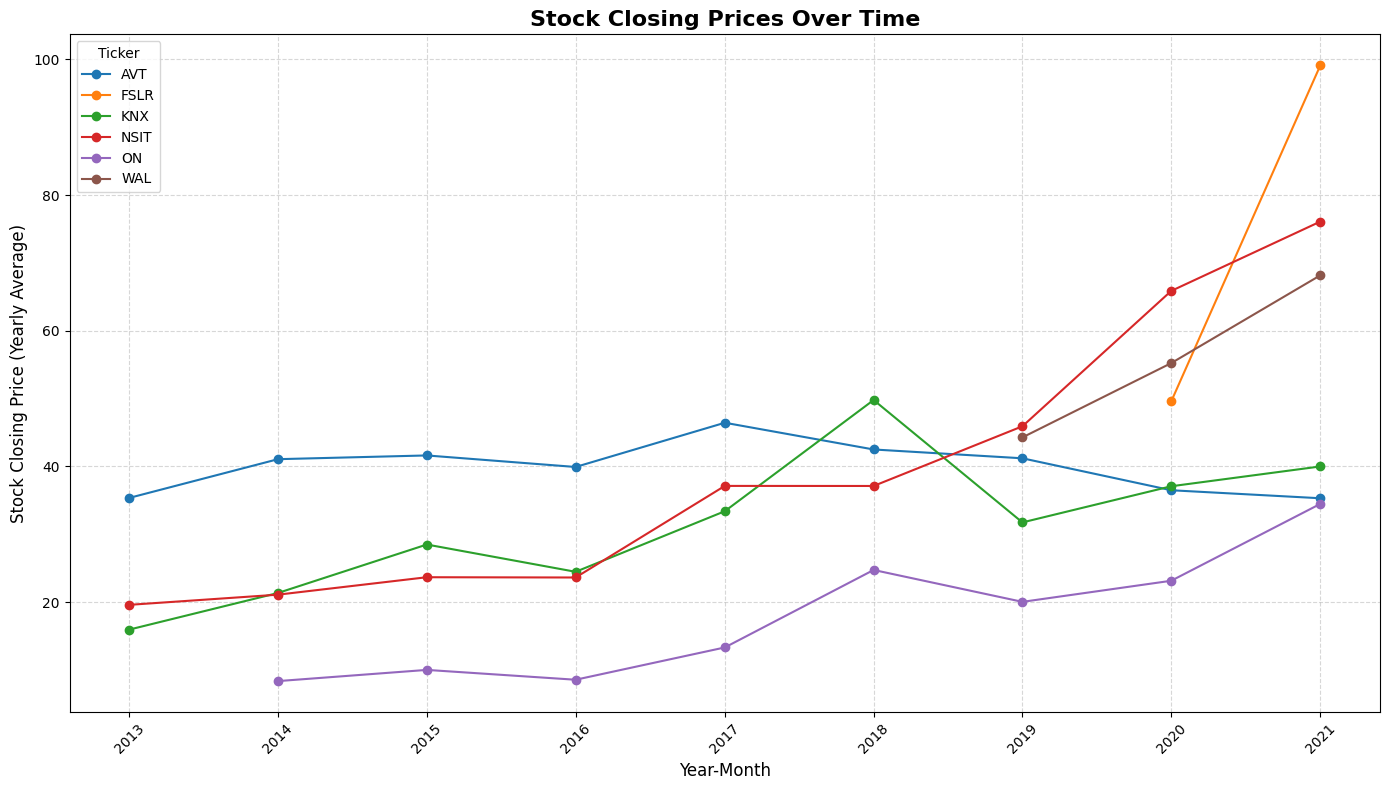

In [80]:
plt.figure(figsize=(14, 8))
for ticker in merged_data["Ticker"].unique():
    subset = merged_data[merged_data["Ticker"] == ticker]
    plt.plot(
        subset["YearMonth"].dt.to_timestamp(),
        subset["Close"],
        label=ticker,
        marker="o"
    )

plt.title("Stock Closing Prices Over Time", fontsize=16, weight='bold')
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Stock Closing Price (Yearly Average)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper left', title="Ticker")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


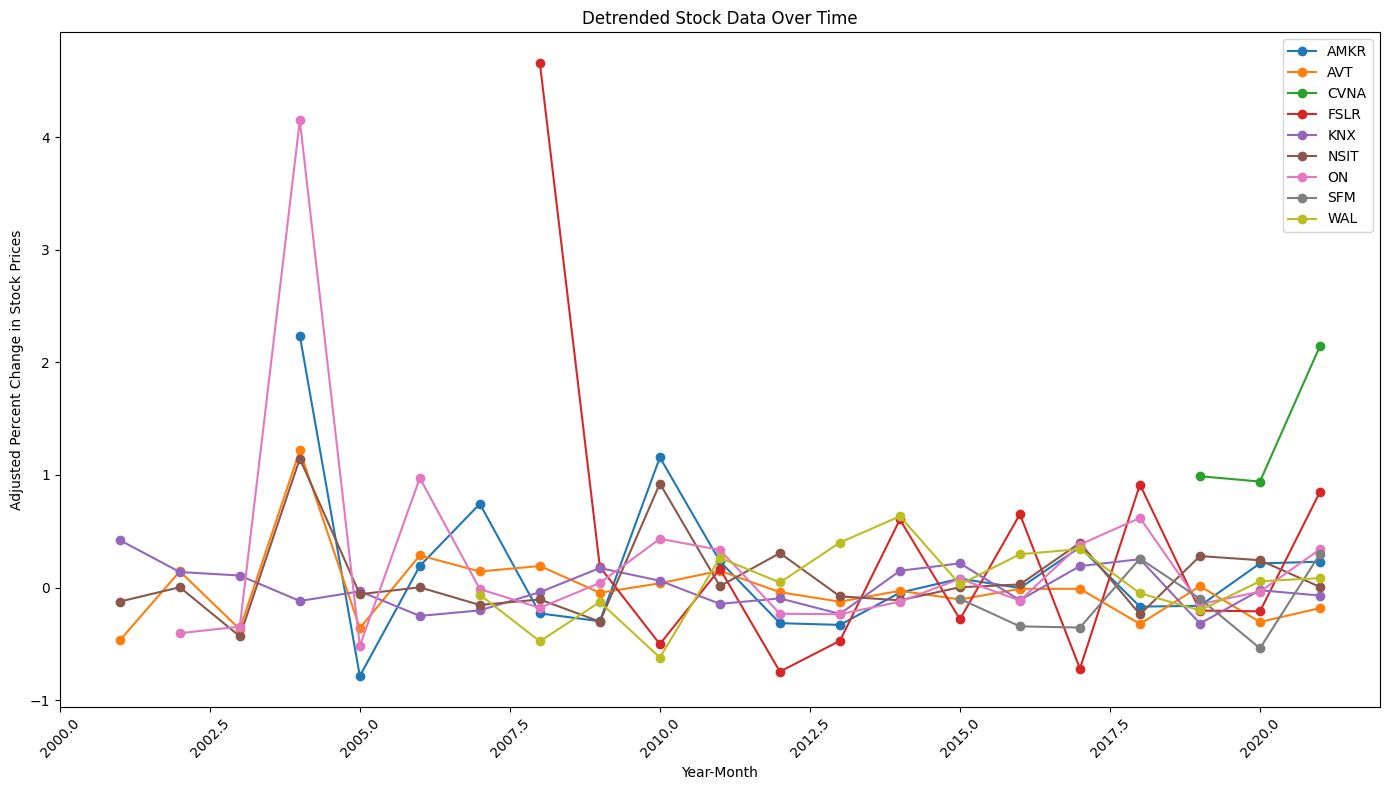

In [ ]:
plt.figure(figsize=(14, 8))
for ticker in merged_data["Ticker"].unique():
    subset = merged_data[merged_data["Ticker"] == ticker]
    plt.plot(subset["Year"].astype(int), subset["Adjusted Stock Change"], label=ticker, marker="o")

plt.title("Detrended Stock Data Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Adjusted Stock Change in Stock Prices")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

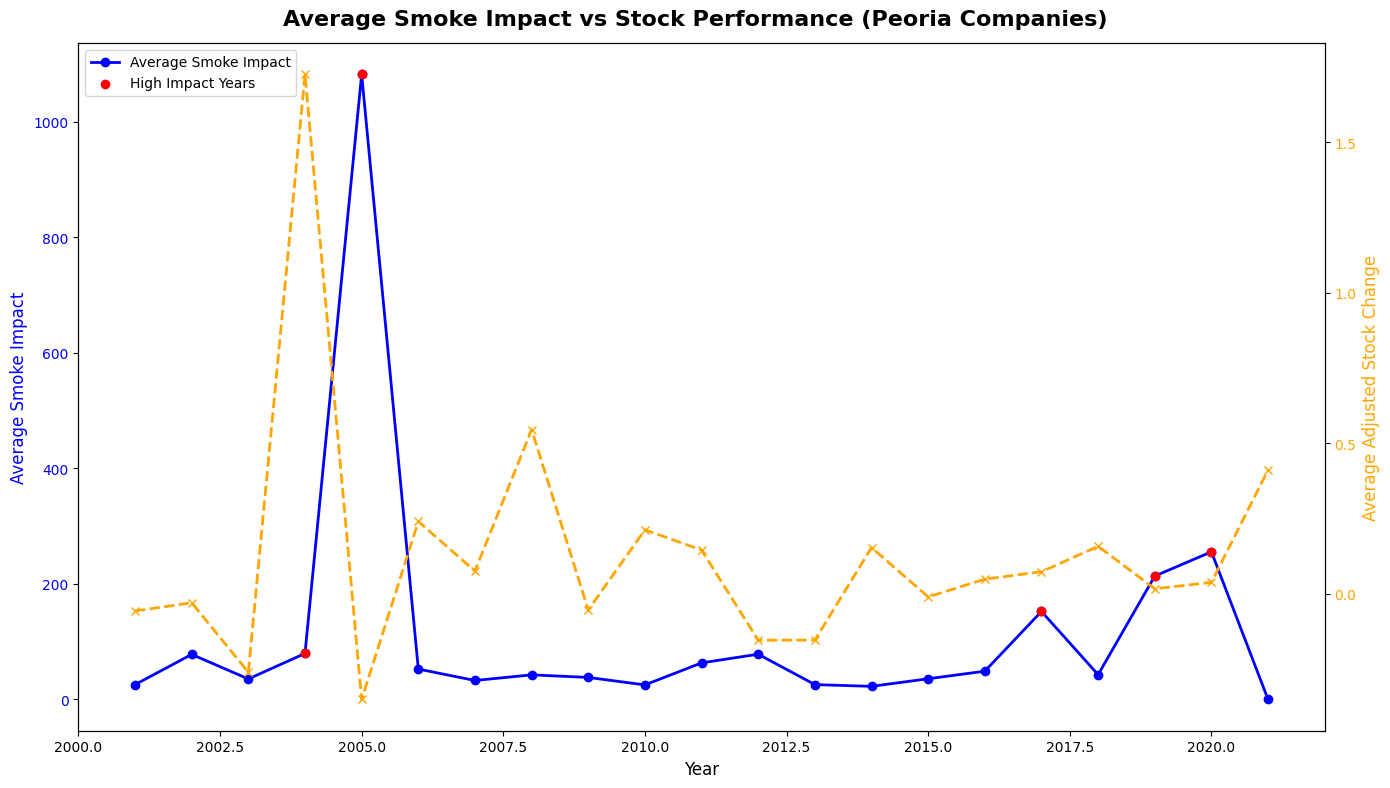

In [40]:
aggregated_data = merged_data.groupby("Year")[["Smoke Impact", "Adjusted Stock Change"]].mean().reset_index()

# Step 10: Highlight Key Years with Dual Axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Smoke Impact
color = "blue"
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Average Smoke Impact", color=color, fontsize=12)
ax1.plot(aggregated_data["Year"], aggregated_data["Smoke Impact"], marker="o", color=color, label="Average Smoke Impact", linewidth=2)
ax1.tick_params(axis="y", labelcolor=color)

# Stock Performance
ax2 = ax1.twinx()
color = "orange"
ax2.set_ylabel("Average Adjusted Stock Change", color=color, fontsize=12)
ax2.plot(aggregated_data["Year"], aggregated_data["Adjusted Stock Change"], marker="x", color=color, label="Adjusted Stock Change", linewidth=2, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)

# Highlight years with high smoke impact
high_impact_years = aggregated_data[aggregated_data["Smoke Impact"] > aggregated_data["Smoke Impact"].quantile(0.75)]
ax1.scatter(high_impact_years["Year"], high_impact_years["Smoke Impact"], color="red", zorder=5, label="High Impact Years")

# Title and legend
fig.suptitle("Average Smoke Impact vs Stock Performance (Peoria Companies)", fontsize=16, weight="bold")
ax1.legend(loc="upper left")
fig.tight_layout()
plt.show()

## Feature Engineering

In this step, lagged features are introduced to capture temporal dependencies, providing insights into how past values of smoke impact and adjusted stock changes affect future performance. The features are then standardized for compatibility with machine learning models, ensuring that all variables are on a similar scale.

#### Old

In [48]:
# Lagged features for time series prediction
for lag in range(1, 4):
    merged_data[f"Smoke Impact Lag {lag}"] = merged_data["Smoke Impact"].shift(lag)
    merged_data[f"Adjusted Stock Change Lag {lag}"] = merged_data["Adjusted Stock Change"].shift(lag)

merged_data.dropna(inplace=True)

# Features and target
features = [
    "Smoke Impact", "Smoke Impact Lag 1", "Smoke Impact Lag 2", "Smoke Impact Lag 3",
    "Adjusted Stock Change Lag 1", "Adjusted Stock Change Lag 2"
]
target = "Adjusted Stock Change"

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data[features])
y = merged_data[target]


#### New

In [61]:
# Lagged features for time series prediction
for lag in range(1, 4):
    merged_data[f"Smoke Impact Lag {lag}"] = merged_data["Smoke Impact"].shift(lag)
    merged_data[f"Adjusted Stock Change Lag {lag}"] = merged_data["Adjusted Stock Change MA"].shift(lag)

merged_data.dropna(inplace=True)

# Features and target
features = [
    "Smoke Impact", "Smoke Impact Lag 1", "Smoke Impact Lag 2", "Smoke Impact Lag 3",
    "Adjusted Stock Change Lag 1", "Adjusted Stock Change Lag 2"
]
target = "Adjusted Stock Change MA"

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data[features])
y = merged_data[target]


## Modeling

### Gradient Boosting Regression

A Gradient Boosting model is trained to predict adjusted stock changes based on engineered features. This section evaluates the model using metrics like Mean Squared Error (MSE) and R-squared, offering a baseline for comparing other approaches. Gradient Boosting is chosen for its ability to handle complex, nonlinear relationships.

#### New

In [68]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [70]:
# Evaluate the model
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Gradient Boosting Model - MSE: {mse:.4f}, R²: {r2:.4f}")

Gradient Boosting Model - MSE: 0.0017, R²: 0.1986


#### Old

In [50]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Grid search for Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [51]:
# Best model
best_gb_model = grid_search.best_estimator_

In [66]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [67]:
# Evaluate the model
y_pred = best_gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Optimized Gradient Boosting Model - MSE: {mse:.4f}, R²: {r2:.4f}")

ValueError: X has 6 features, but GradientBoostingRegressor is expecting 7 features as input.

### LSTM Model

This section implements an LSTM (Long Short-Term Memory) neural network to capture sequential dependencies in the data. LSTM is particularly suitable for time-series data, where understanding the order of observations is critical. The model's performance is evaluated, and its predictions are compared to the Gradient Boosting model.

#### New

In [71]:
# Prepare data for LSTM
sequence_length = 5
X_lstm = []
y_lstm = []
for i in range(sequence_length, len(X)):
    X_lstm.append(X[i-sequence_length:i])
    y_lstm.append(y.iloc[i])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Train-test split
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [72]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/20


C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0054 - val_loss: 0.0037
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0033 - val_loss: 0.0073
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0033 - val_loss: 0.0073
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0033 - val_loss: 0.0069
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0028 - val_loss: 0.0048
Epo

In [73]:
# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Model - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
LSTM Model - MSE: 0.0076, R²: -5.5804


In [74]:
from tensorflow.keras.callbacks import EarlyStopping

# Adjust sequence length
sequence_length = 10
X_lstm, y_lstm = [], []
for i in range(sequence_length, len(X)):
    X_lstm.append(X[i-sequence_length:i])
    y_lstm.append(y.iloc[i])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Train-test split
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm),
               callbacks=[early_stopping])

# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"Adjusted LSTM Model - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}")


Epoch 1/50


C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0039 - val_loss: 0.0015
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0019 - val_loss: 0.0015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Adjusted LSTM Model - MSE: 0.0012, R²: -0.1141


## Visualization
Predictions from both models are visualized to compare actual versus predicted values. These plots help assess the models' effectiveness in capturing the relationship between smoke impact and stock performance and provide a visual summary of their accuracy.

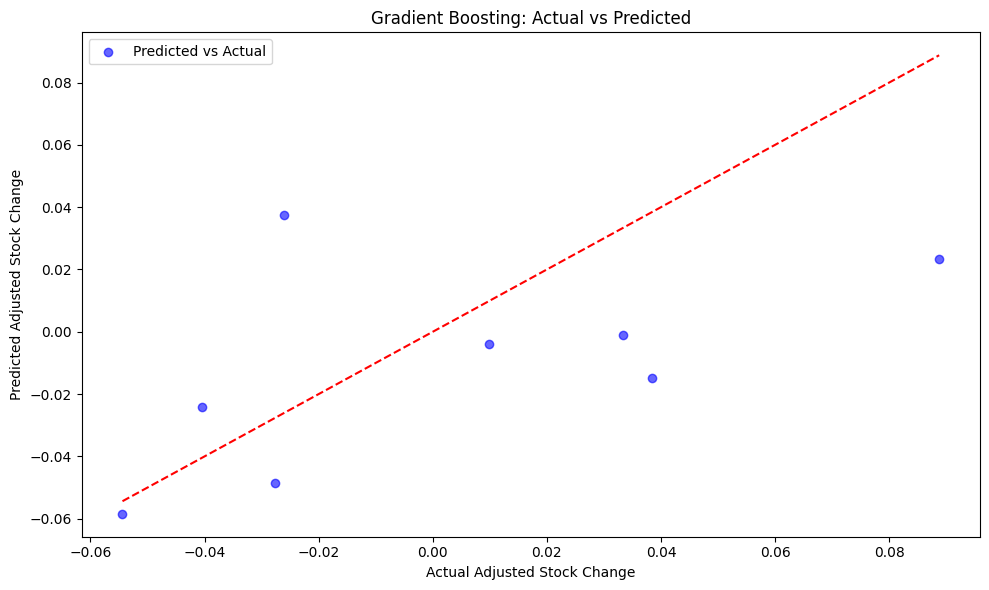

In [78]:
# Gradient Boosting Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Adjusted Stock Change")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("Gradient Boosting: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

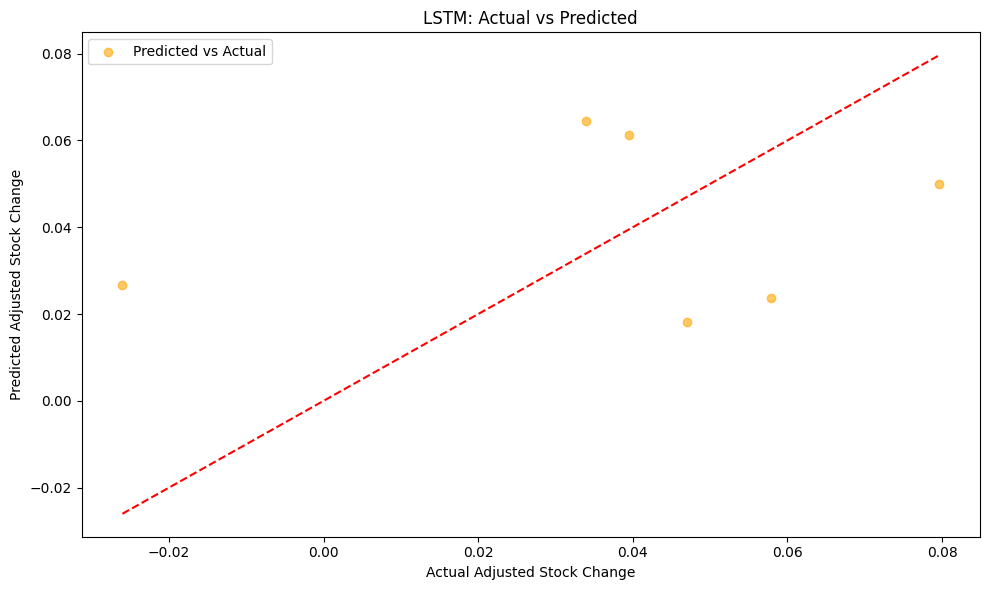

In [79]:
# LSTM Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, color="orange", label="Predicted vs Actual")
plt.plot([y_test_lstm.min(), y_test_lstm.max()], [y_test_lstm.min(), y_test_lstm.max()], color="red", linestyle="--")
plt.xlabel("Actual Adjusted Stock Change")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("LSTM: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()


## Forecasting

Future scenarios of smoke impact are generated, and their economic implications are predicted using both models. This section provides stakeholders with actionable insights into potential future outcomes, assisting in planning and decision-making processes. Predictions are visualized to illustrate the projected trends and their implications.

#### Old

In [17]:
# Generate future smoke impact scenarios
future_smoke = np.linspace(merged_data["Smoke Impact"].min(), merged_data["Smoke Impact"].max(), 50).reshape(-1, 1)
future_sp500 = np.zeros_like(future_smoke)
future_features = np.hstack([future_smoke, future_sp500, np.zeros((50, len(features) - 2))])

# Scale features
future_features_scaled = scaler.transform(future_features)

C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
# Predict using Gradient Boosting
future_pred_gb = gb_model.predict(future_features_scaled)


In [19]:
# Predict using LSTM
future_pred_lstm = lstm_model.predict(future_features_scaled[:, np.newaxis, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step 


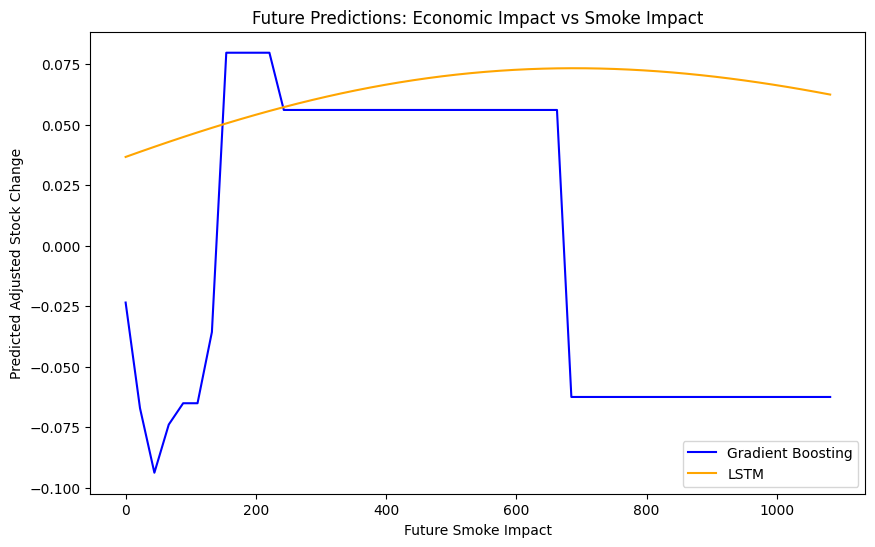

In [20]:
# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(future_smoke, future_pred_gb, label="Gradient Boosting", color="blue")
plt.plot(future_smoke, future_pred_lstm, label="LSTM", color="orange")
plt.xlabel("Future Smoke Impact")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("Future Predictions: Economic Impact vs Smoke Impact")
plt.legend()


#### New

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


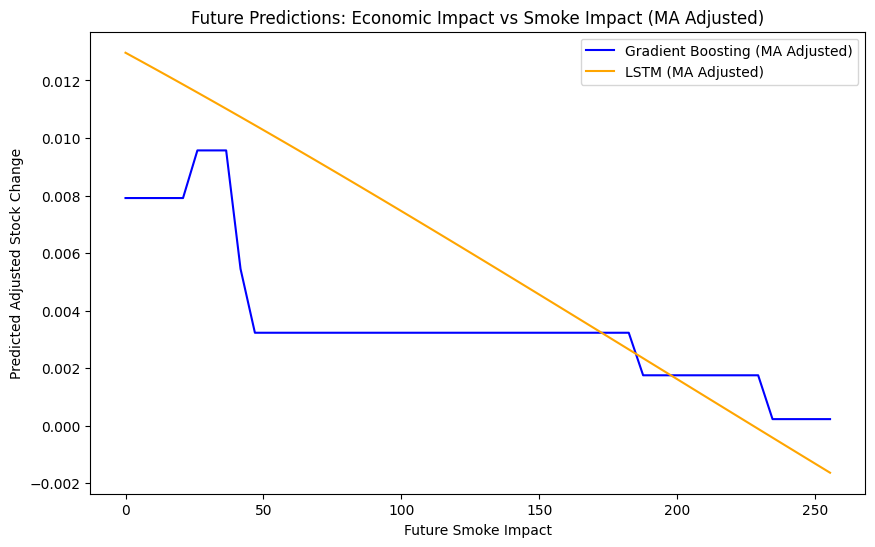

In [77]:
# Generate future smoke impact scenarios
future_smoke = np.linspace(merged_data["Smoke Impact"].min(), merged_data["Smoke Impact"].max(), 50).reshape(-1, 1)
future_features = np.hstack([future_smoke, np.zeros((50, len(features) - 1))])

# Scale features
future_features_scaled = scaler.transform(future_features)

# Predict using Gradient Boosting
future_pred_gb = gb_model.predict(future_features_scaled)

# Predict using LSTM
future_pred_lstm = lstm_model.predict(future_features_scaled[:, np.newaxis, :])

# Plot forecasts
plt.figure(figsize=(10, 6))
plt.plot(future_smoke, future_pred_gb, label="Gradient Boosting (MA Adjusted)", color="blue")
plt.plot(future_smoke, future_pred_lstm, label="LSTM (MA Adjusted)", color="orange")
plt.xlabel("Future Smoke Impact")
plt.ylabel("Predicted Adjusted Stock Change")
plt.title("Future Predictions: Economic Impact vs Smoke Impact (MA Adjusted)")
plt.legend()
plt.show()


## Predict Future Smoke Estimates (2025-2050), From Part 1 of the analysis 

In [43]:
# Prepare data for predictive model
X = smoke_data[["Year"]].values
y = smoke_data["Smoke Impact"].values

In [44]:
# Train a simple linear regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [45]:
# Forecast for the years 2025-2050
future_years = np.array(range(2025, 2051)).reshape(-1, 1)
predicted_smoke = model.predict(future_years)

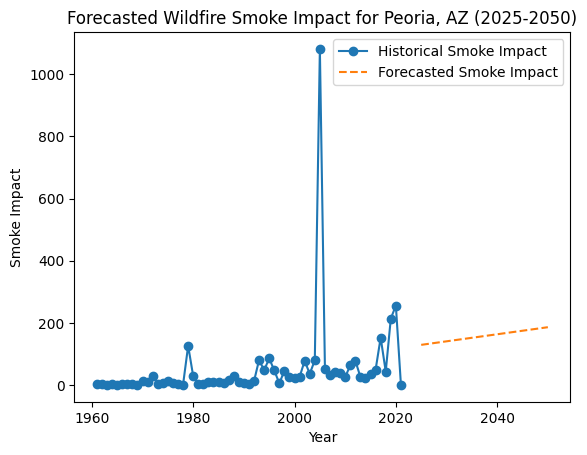

In [47]:
# Plot forecasted smoke impact
plt.plot(smoke_data["Year"], smoke_data["Smoke Impact"], label="Historical Smoke Impact", marker="o")
plt.plot(future_years.flatten(), predicted_smoke, label="Forecasted Smoke Impact", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Smoke Impact")
plt.legend()
plt.title("Forecasted Wildfire Smoke Impact for Peoria, AZ (2025-2050)")
plt.show()

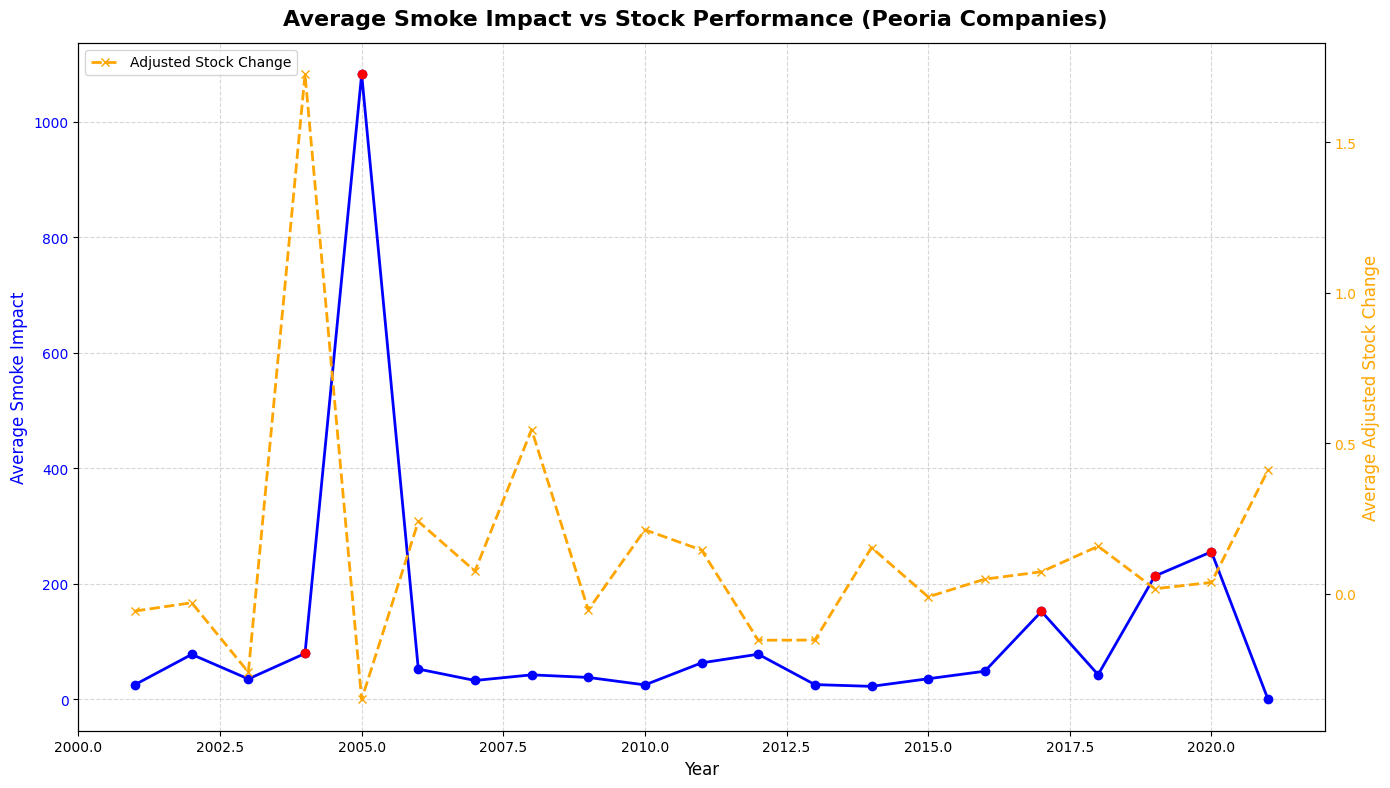

In [83]:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Smoke Impact
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Average Smoke Impact", color="blue", fontsize=12)
ax1.plot(
    aggregated_data["Year"], 
    aggregated_data["Smoke Impact"], 
    marker="o", color="blue", label="Average Smoke Impact", linewidth=2
)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(visible=True, linestyle="--", alpha=0.5)

# Stock Performance
ax2 = ax1.twinx()
ax2.set_ylabel("Average Adjusted Stock Change", color="orange", fontsize=12)
ax2.plot(
    aggregated_data["Year"], 
    aggregated_data["Adjusted Stock Change"], 
    marker="x", color="orange", label="Adjusted Stock Change", linewidth=2, linestyle="--"
)
ax2.tick_params(axis="y", labelcolor="orange")

# Highlight high smoke impact years
high_impact_years = aggregated_data[aggregated_data["Smoke Impact"] > aggregated_data["Smoke Impact"].quantile(0.75)]
ax1.scatter(
    high_impact_years["Year"], 
    high_impact_years["Smoke Impact"], 
    color="red", zorder=5, label="High Impact Years"
)

# Title and legend
fig.suptitle("Average Smoke Impact vs Stock Performance (Peoria Companies)", fontsize=16, weight="bold")
fig.tight_layout()
plt.legend(fontsize=10, loc="upper left")
plt.show()


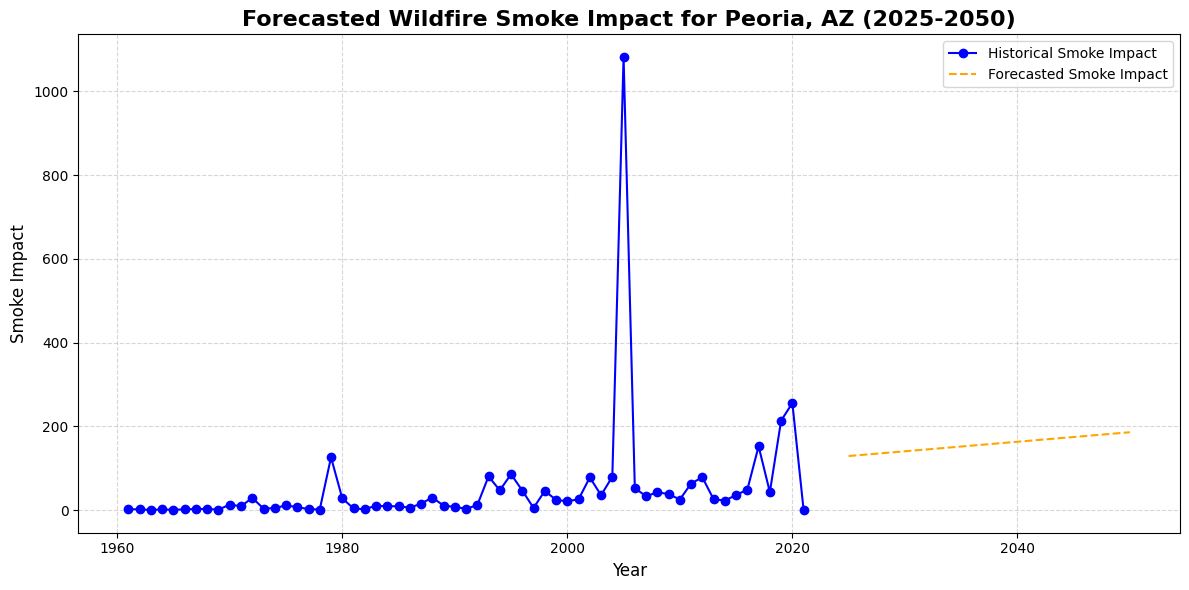

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(
    smoke_data["Year"], 
    smoke_data["Smoke Impact"], 
    label="Historical Smoke Impact", marker="o", color="blue"
)
plt.plot(
    future_years.flatten(), 
    predicted_smoke, 
    label="Forecasted Smoke Impact", linestyle="--", color="orange"
)
plt.title("Forecasted Wildfire Smoke Impact for Peoria, AZ (2025-2050)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Smoke Impact", fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\amitp\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


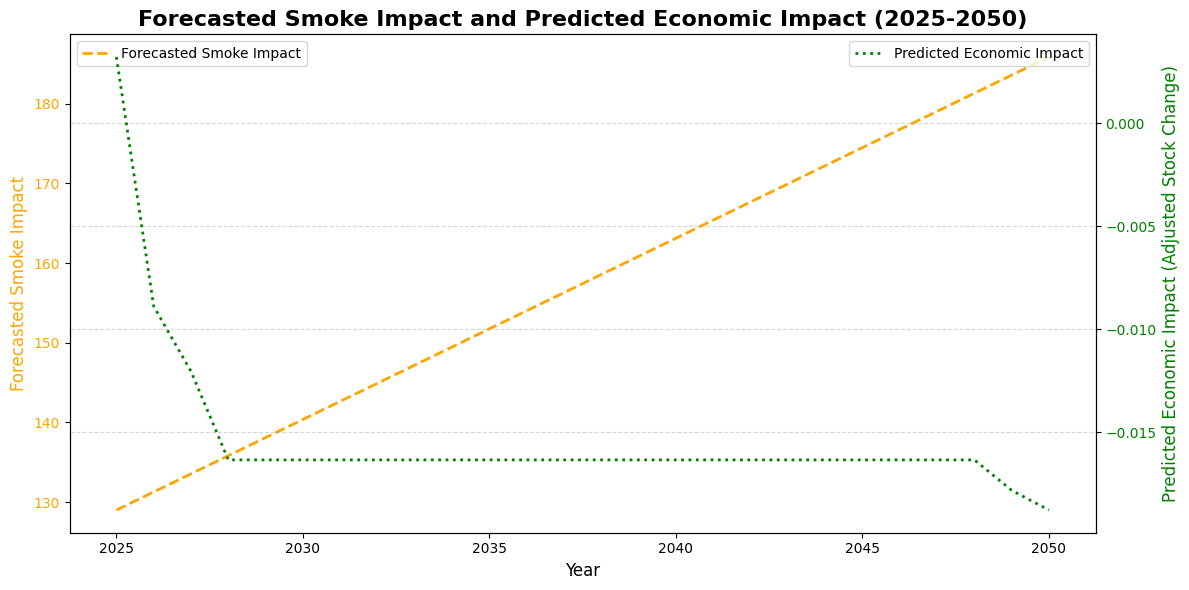

In [90]:
# Create lagged Smoke Impact features
future_features = np.zeros((len(predicted_smoke), len(features)))
future_features[:, 0] = predicted_smoke  # Set the Smoke Impact feature

# Fill in lagged Smoke Impact features
for lag in range(1, 4):  # Smoke Impact Lag 1 to Lag 3
    future_features[lag:, lag] = predicted_smoke[:-lag]

# Assume Adjusted Stock Change lags are zero (no prior predictions available)
# This simplifies future forecasting but might introduce some approximation errors.
for lag in range(4, 6):  # Adjusted Stock Change Lag 1 and Lag 2
    future_features[:, lag] = 0

# Scale features
future_features_scaled = scaler.transform(future_features)

# Predict using Gradient Boosting
future_adjusted_stock_change = gb_model.predict(future_features_scaled)

# Dual-axis plot for forecasted smoke impact and economic impact
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot forecasted smoke impact on the primary y-axis
color = "orange"
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Forecasted Smoke Impact", color=color, fontsize=12)
ax1.plot(
    future_years.flatten(),
    predicted_smoke,
    label="Forecasted Smoke Impact",
    linestyle="--",
    color=color,
    linewidth=2
)
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left", fontsize=10)

# Plot predicted economic impact on the secondary y-axis
ax2 = ax1.twinx()
color = "green"
ax2.set_ylabel("Predicted Economic Impact (Adjusted Stock Change)", color=color, fontsize=12)
ax2.plot(
    future_years.flatten(),
    future_adjusted_stock_change,
    label="Predicted Economic Impact",
    linestyle=":",
    color=color,
    linewidth=2
)
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right", fontsize=10)

# Title and grid
plt.title("Forecasted Smoke Impact and Predicted Economic Impact (2025-2050)", fontsize=16, weight="bold")
plt.grid(visible=True, linestyle="--", alpha=0.5)
fig.tight_layout()

# Show the plot
plt.show()
